In [50]:
import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# Load data

In [51]:
path0 = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator'

In [52]:
# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file)

In [55]:
# load metrics
files=[
    "evaluation_many_metrics.csv",
    "evaluation_many_metrics_mosart_s-1.csv", # shift time step by -1
    "evaluation_many_metrics_mizuroute_s-1.csv", # shift time step by -1
    ]

types = ['CLM', 'MOSART_MaxGrid_s-1', 'mizuroute_s-1', ]

numtrial = 200

outfile = 'iter0_kge_clm_mosart_mizu.npz'
if  os.path.isfile(outfile):
    dtmp = np.load(outfile)
    metric_all = dtmp['metric_all']

else:

    metric_all = np.nan * np.zeros([len(df_info), len(types), 200])
    
    for i in range(len(df_info)):
        if np.mod(i, 50) == 0:
            print('Processing basin', i)
        for j in range(len(types)):
            for t in range(numtrial):
                fileij = f'{path0}/level1_{i}_calib/ctsm_outputs/iter0_trial{t}/{files[j]}'
                if not os.path.isfile(fileij):
                    print('Cannot find', fileij)
                else:
                    dfij = pd.read_csv(fileij)
                    metric_all[i,j,t] = np.squeeze(dfij['kge'].values)
    
    np.savez_compressed(outfile, metric_all=metric_all, types=types)

# Analyze

In [56]:
for i in range(3):
    di = np.nanmax(metric_all[:,i,:], axis=1)
    print('Basins without valid KGE from iter-0', types[i], np.sum(np.isnan(di)))


for i in range(3):
    di = metric_all[:,i,0]
    print('Median Default KGE', types[i], np.nanmedian(di))

for i in range(3):
    di = np.nanmax(metric_all[:,i,:], axis=1)
    print('Median Best KGE from iter-0', types[i], np.nanmedian(di))

for i in range(3):
    di = np.nanmax(metric_all[:,i,:], axis=1)
    print('Mean Best KGE from iter-0', types[i], np.nanmean(di))


Basins without valid KGE from iter-0 CLM 0
Basins without valid KGE from iter-0 MOSART_MaxGrid_s-1 9
Basins without valid KGE from iter-0 mizuroute_s-1 0
Median Default KGE CLM 0.1952032652918867
Median Default KGE MOSART_MaxGrid_s-1 0.23828694330024042
Median Default KGE mizuroute_s-1 0.2924950605896708
Median Best KGE from iter-0 CLM 0.489003496598709
Median Best KGE from iter-0 MOSART_MaxGrid_s-1 0.5321213654036057
Median Best KGE from iter-0 mizuroute_s-1 0.5029821806262613
Mean Best KGE from iter-0 CLM 0.4321844499484068
Mean Best KGE from iter-0 MOSART_MaxGrid_s-1 0.48459400233773
Mean Best KGE from iter-0 mizuroute_s-1 0.46907224865696284


/glade/derecho/scratch/guoqiang/tmp/ipykernel_1389/1188946395.py:2: RuntimeWarning: All-NaN slice encountered
  di = np.nanmax(metric_all[:,i,:], axis=1)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_1389/1188946395.py:11: RuntimeWarning: All-NaN slice encountered
  di = np.nanmax(metric_all[:,i,:], axis=1)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_1389/1188946395.py:15: RuntimeWarning: All-NaN slice encountered
  di = np.nanmax(metric_all[:,i,:], axis=1)


/glade/derecho/scratch/guoqiang/tmp/ipykernel_1389/4016624915.py:10: RuntimeWarning: All-NaN slice encountered
  di = np.nanmax(metric_all[:,i,:], axis=1)


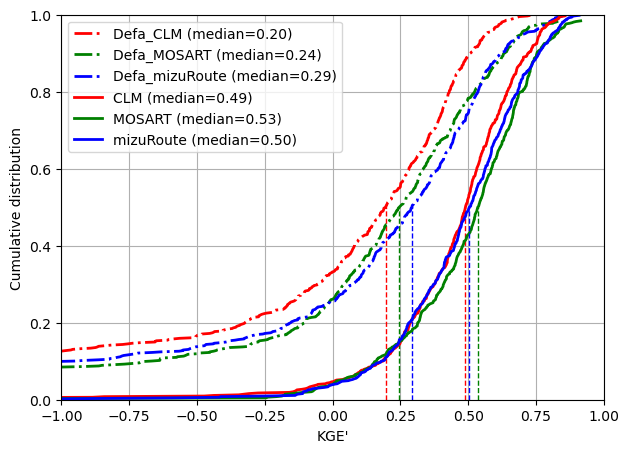

In [57]:
# plot CDF curves of those methods

kge_all = []

for i in range(3):
    di = metric_all[:,i,0]
    kge_all.append(di)
    
for i in range(3):
    di = np.nanmax(metric_all[:,i,:], axis=1)
    kge_all.append(di)

names = ['Defa_CLM', 'Defa_MOSART', 'Defa_mizuRoute', 'CLM', 'MOSART', 'mizuRoute']

# Set up a figure for plotting
fig = plt.figure(figsize=[7, 5])

# Define custom colors for better comparison
colors = ['r', 'g', 'b', 'r', 'g', 'b']
lines = ['-.', '-.', '-.', '-','-','-']

# Loop over each method and plot the CDF curves
for i in range(len(names)):
    di = np.sort(kge_all[i])  # Sort values for CDF
    xi = np.arange(len(di)) / len(di)  # Calculate cumulative distribution

    xmloc = np.argmin( np.abs(xi-0.5) )
    dmid = di[xmloc]

    plt.plot(di, xi, f'{lines[i]}{colors[i]}', label=f'{names[i]} (median={dmid:.2f})', linewidth=2)

    plt.plot([dmid, dmid], [0, 0.5] , '--', color=colors[i], linewidth=1)


# Set y and x axis limits and labels
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel("KGE'")
plt.ylabel("Cumulative distribution")

# Add a legend
plt.legend()
plt.grid('on')

# Display the plot
plt.show()